# Predicting the Stock Market with Google Trends
I think that doing a linear regression is hard since there's a lag between the searches and the stock market behaviour. The papers don't actually do a linear regression per-se, they instead do a buy/sell trade algorithm.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas_datareader import data as web
import glob
import matplotlib.pyplot as plt
from sklearn.cross_validation import cross_val_score
%matplotlib inline

# Prepare data

In [7]:
#Load Google Trends data
files = glob.glob("GoogleTrends/*.csv")

#look at first file and get location of last entry, as well as the dates
GT = pd.read_csv(files[0],header=4,skip_blank_lines=False)
tail = np.where(pd.isnull(GT))[0][0]-2

#get dates in integer and string format for each friday (gotta get down on friday)
#i.e. to match GT data with the Weekly Adj Close prices
GT_dates_int = []
GT_dates_str = []
for date in GT.loc[0:tail].iterrows():
    d = date[1][0].split(" - ")[1].split("-")
    GT_dates_int.append(int(d[0]+d[1]+d[2])-1)
    day = int(d[2])-1
    if day < 10:
        day = "0"+str(day)
    else:
        day = str(day)
    GT_dates_str.append(d[0]+"-"+d[1]+"-"+day)

In [16]:
#load all Google Trends data
cols = [] 
for f in files:
    df = pd.read_csv(f,header=None,skiprows=4,skip_blank_lines=False)
    df = df.loc[0:tail+1]
    cols.append(df.iloc[:,1])
GT = pd.concat(cols,axis=1,names=cols)
GT.columns = GT.iloc[0]
GT = GT.iloc[1:].astype(float)
GT = GT.reset_index(drop=True)

In [17]:
#how you want to prepare your GT data (differencing, difference from rolling average, or normalization)
choice = "diff"
rolling_dt = 4
rolling_monthly = 4

if choice == "diff": #simple difference
    GT = GT.diff()
    rolling_dt = 1
elif choice == "rolling_diff": #rolling difference
    rolling = GT.rolling(window=rolling_dt).mean()
    GT = GT - rolling
elif choice == "norm": #calculate z-statistic
    GT = (GT - GT.mean())/GT.std()
    
#get dates
GT.insert(0,"Dates",GT_dates_int)
GT = GT.iloc[rolling_dt:]

#Get all S&P500 data
t0 = [int(x) for x in GT_dates_str[0].split("-")]    #start of Google Trends
t1 = [int(x) for x in GT_dates_str[-1].split("-")]   #End of Google Trends
start = datetime(t0[0], t0[1], t0[2])
end = datetime(t1[0], t1[1], t1[2])
data = web.DataReader('^GSPC','yahoo', start, end)
stock_dates = []

#get dates in integer form
for date in data.iterrows():
    d = str(date[0].date()).split("-")
    stock_dates.append(int(d[0]+d[1]+d[2]))

#Take closing prices (i.e. end of week) only on dates coresponding to Google Trend dates
data.insert(0,"Dates",stock_dates)
data = data.loc[data["Dates"].isin(GT_dates_int)]

#get change in price, much more predictive
data["Weekly Change"] = data["Adj Close"].diff() 
data["Monthly Std"] = data["Adj Close"].rolling(window=rolling_monthly).std()
data = data.iloc[max(rolling_dt,rolling_monthly):]

#ensure that Google Trends data aligns with stock data too
GT = GT[GT["Dates"].isin(data["Dates"])]

## Check for Unit Root (and Stationarity) - Augmented Dicker-Fuller (ADF) test
The Dicker-Fuller test checks the null hypothesis that an auto-regressive process has a unit root. An auto-regressive process is described by:
$$X(t) = \sum_{i=1}^t \rho_i X(t-i) + RAND(t) + c$$

When the size of a root is greater than unity ($\rho > 1$) the flow accelerates away from a central location (e.g. picture streamlines of water flowing down a creek). $\rho > 1$ typically doesn't happen often in economic data. Movement along a characteristic direction with a unit root ($\rho = 1$) is dominated by the random forces affecting the cone. It is a "random walk". The cone can wander away slowly but without accelerating. However, if $\rho < 1$ the process is mean-reverting. 

It is key to remember that ADF tests for a unit root (i.e. $\rho = 1$), not for stationarity per-se. A process is only (covariance) stationary if it has time-invariant 1st and 2nd moments.

A couple notes:
* The model for ADF is: $\Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \delta_1 \Delta y_{t-1} + ... + \delta_{p-1} \Delta y_{t-(p-1)}$, where $p$ is the order of the autoregressive process, i.e. how far back does previous data influence new data? The order is usually calculated by maxmimizing the information criterion, i.e. the Akaike Information Criterion (AIC), Bayesian Information Criterion (BIC), etc.
* When assessing the Test Statistic for stationarity, remember that if the **signed** test statistic is less than the Critical Values it implies that all roots are less than 1, i.e. the more negative the Test Statistic the more likely your time series is to be stationary.

Useful Links:
* http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.adfuller.html - using adfuller
* https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/ - discussion of time series analysis and stationary processes
* http://stats.stackexchange.com/questions/29121/intuitive-explanation-of-unit-root - great intuition of unit root

In [18]:
#The (signed) test statistic must be less than the Critical values
from statsmodels.tsa.stattools import adfuller
def dickey_fuller(timeseries):
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

In [19]:
#dickey_fuller(data["Weekly Change"])
dickey_fuller(GT["debt"])

Results of Dickey-Fuller Test:
Test Statistic                -1.154327e+01
p-value                        3.591549e-21
# Lags Used                    9.000000e+00
Number of Observations Used    5.970000e+02
Critical Value (5%)           -2.866393e+00
Critical Value (1%)           -3.441351e+00
Critical Value (10%)          -2.569355e+00
dtype: float64


## Check for Normality - Compare to Normal Distribution
The ADF test has given us evidence that the differenced time series, i.e. "Weekly Change" is stationary. But is it normal? 

Here we compare the time series to a normal distribution, and check the null hypothesis that the distribution comes from a normal distribution. Thus, if the p-value returned is less than the a given threshold, we reject the null hypothesis that the Weekly Changes are normally distributed. Keep in mind that a check for normality is different than a check for stationarity. A distribution can be stationary (constant mean and variance) and not follow a normal distribution.

When plotting the S&P500 Weekly Changes it already becomes clear that the data is not normally distributed. 8-sigma events show up in the Weekly Change histogram, which statistically should not happen in our lifetime if the data was truly normally distributed. In addition, it is also more sharply peaked.

NormaltestResult(statistic=109.73422225357285, pvalue=1.4842819278997192e-24)


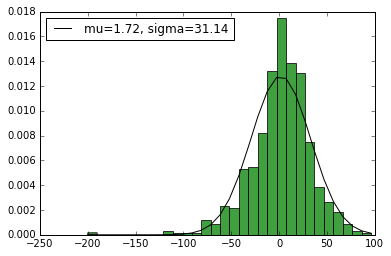

In [20]:
from scipy.stats import norm
from scipy.stats.mstats import normaltest

field = "Weekly Change"
x = data[field]

test = normaltest(x)
print test
(mu, sigma) = norm.fit(x)

n, bins, patches = plt.hist(x, 30, normed=1, facecolor='green', alpha=0.75)
plt.plot(bins, norm.pdf(bins,mu,sigma), color='black', label='mu=%.2f, sigma=%.2f'%(mu,sigma))
plt.legend(loc='upper left')

## Tests for Causality - Granger Causality Tests
The maximum lag for the Granger Causality Test needs to be at least as large as the "# lags used" in the ADF test?
It's important to remember that "Granger Causality" is not true causality, and more-so measures correlation/predictability of lagged datasets. For example, a crowing rooster may Granger Cause the rising of the sun every morning at 6am, but obviously, the crowing rooster doesn't truly cause the rising of the sun. 


Useful Links:
* http://davegiles.blogspot.ca/2011/04/testing-for-granger-causality.html
* https://en.wikipedia.org/wiki/Vector_autoregression

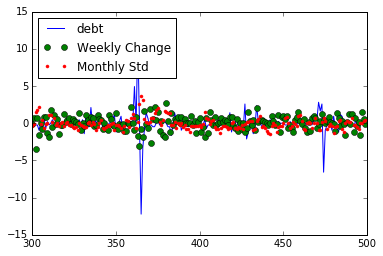

In [22]:
from statsmodels.tsa.stattools import grangercausalitytests

#create arrays
fieldx = "debt"
fieldy = "Weekly Change"
tt = range(len(GT[fieldx]))
yy = (data[fieldy] - data[fieldy].mean())/data[fieldy].std()
xx = (GT[fieldx] - GT[fieldx].mean())/GT[fieldx].std()
zz = (data["Monthly Std"] - data["Monthly Std"].mean())/data["Monthly Std"].std()

#truncate - look at just 2008 financial crisis
min_ = 300
max_ = 500
xx = xx[min_:max_]
yy = yy[min_:max_]
zz = zz[min_:max_]
tt = tt[min_:max_]

#granger test
maxlag = 10
#result = grangercausalitytests(zip(yy,xx),maxlag)

#plot
plt.plot(tt,xx)
plt.plot(tt,yy,'o')
plt.plot(tt,zz,'.')
plt.legend(loc="upper left")
#plt.xticks(tt, GT["Dates"], rotation=45)

# Onto Machine Learning

## Linear Regression

In [ ]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

columns = ["debt"]
Xs = StandardScaler().fit_transform(GT[columns])

#want a clean split of test/train data, not random sampling throughout time series
test_size = 0.15 
N = len(y)
split = int(N*(1-test_size))
Xs_train, Xs_test, ys_train, ys_test = Xs[0:split], Xs[split:], ys[0:split], ys[split:] #scaled data

regr = linear_model.LinearRegression()
regr.fit(Xs_train, ys_train)
print "coefficient of determination R^2 of the prediction:",regr.score(Xs_test, ys_test)
print "MSE is:",cross_val_score(regr, Xs_test, ys_test, scoring='mean_squared_error').mean()
print "\nModel coefficients are:" 
for i in range(len(columns)):
    print("%s\t\t%f" % (columns[i], regr.coef_[i]))

In [ ]:
t = range(len(ys_test))
plt.plot(t, ys_test, 'o')
plt.plot(t,regr.predict(Xs_test))

## Random Forest

In [ ]:
columns = GT.columns[1:]
X = GT[columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
rfr = RandomForestRegressor(max_features='auto' ,n_estimators=50, oob_score=1) 
param_grid = { 
        'n_estimators': [300,500],
        'max_features': ['sqrt'],
        'min_samples_split': [2,4,8,12,16]
}
CV_rfr = GridSearchCV(n_jobs=-1, estimator=rfr, scoring="mean_squared_error", param_grid=param_grid)
CV_rfr.fit(X_train, y_train);
print("Best Parameters from gridsearch: {%s} with a score of %0.4f" % (CV_rfr.best_params_, CV_rfr.best_score_))

In [ ]:
modelrfr = CV_rfr.best_estimator_
print("Feature\t\tImportance\n")
for i in reversed(np.argsort(modelrfr.feature_importances_)):
    print("%s\t\t%f" % (columns[i], modelrfr.feature_importances_[i]))

# Extra

## PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
X_PCA = StandardScaler().fit_transform(GT[GT.columns[1:]]) #scale data

pca = PCA(n_components=3)
pca.fit(X_PCA)                 #get PCs of scaled data
print "The principal components explain "+np.array_str(pca.explained_variance_ratio_)+" of the variance in the data."
pd.DataFrame(pca.components_.T, index=GT.columns[1:])